# Data Cleaning and Feature Engineering

* Focus on businesses in the shopping industry which still operate and located in the United States - reduced the number of businesses from 210k to 20k.
* Accordingly, select only the reviews belong to a shopping business - reduced the number of reviews from 8.2m to 485k
* Sample size for the users reduced from ~2m to 277k

# Import Libraries & Read Data

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))

In [2]:
# import sys
# !{sys.executable} -m pip install textblob
# !{sys.executable} -m pip install googletrans
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install contractions
# !{sys.executable} -m pip install spacy
# !{sys.executable} -m spacy download en

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.classify import TextCat
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
from string import whitespace, punctuation, digits
from langdetect import detect, lang_detect_exception
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import re
import contractions
import spacy
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
# nltk.download('crubadan')
snowball_stemmer = SnowballStemmer('english')
stop_words = stopwords.words('english')
nlp = spacy.load('en', disable=['parser', 'ner'])

In [4]:
df = pd.read_csv('yelp_review_data.csv')
df.head()

,review_id,user_id,business_id,review_stars,review_useful,review_funny,review_cool,review,review_date
0,YkpjR5N5TLkwHi20IZ15zg,xDtS2iKsJuVUVzB2YhfPsg,f9NumwFMBDn751xgFiRbNA,4.0,23,2,4,Driving more than an half-hour to get to a gun...,2012-06-26 00:48:30
1,rB1D3_F5cED234lqvnJK1A,46HhzhpBfTdTSB5ceTx_Og,f9NumwFMBDn751xgFiRbNA,4.0,15,0,3,"My dad came down to the area to visit, and whi...",2012-05-29 23:44:04
2,S5UuPziiDiEqFPuX5bY-kg,vBxT4_bjFrbZEarWz6vsCQ,f9NumwFMBDn751xgFiRbNA,4.0,0,0,0,First time and and last time. I'm a punk!!! 2...,2017-06-18 00:24:54
3,nwEXkyNGhtsRCAv7kS9Urg,qiz4Ri_cMSsoH3ccN19eAw,f9NumwFMBDn751xgFiRbNA,5.0,2,0,0,"Besides being a great range, they are not chea...",2016-02-14 02:28:57
4,oT2weUEWpPOqIAer3MmrCg,0awwOxKGZVDt52vxkEX-eA,f9NumwFMBDn751xgFiRbNA,1.0,2,1,0,"Place is nice to look at, but wouldn't really ...",2014-05-28 20:00:46


In [5]:
# check if there is duplicated reviews
print('There are {} duplicated reviews.'.format(
    df[df.review.duplicated()].shape[0]))

There are 1244 duplicated reviews.


In [6]:
# drop duplicated reviews
df.drop_duplicates(subset='review', keep='first', inplace=True)

# Basic Feature Engineering

In [7]:
df['word_tokens'] = df.review.apply(nltk.word_tokenize)

In [8]:
# Feature engineering
df['length_sent'] = df.review.apply(lambda x: len(nltk.sent_tokenize(x)))
df['length_word'] = df.word_tokens.apply(lambda x: len(x))
df['set_word'] = df.word_tokens.apply(lambda x: len(set([w.lower() for w in x])))
df['length_punct'] = df.review.apply(lambda x: len([p for p in x if p in punctuation]))
df['length_stopwords'] = df.word_tokens.apply(lambda x: len([w for w in x if w.lower() in stop_words]))
df['length_upper'] = df.word_tokens.apply(lambda x: len([w for w in x if w.isupper()]))
df['length_title'] = df.word_tokens.apply(lambda x: len([w for w in x if w.istitle()]))
df['length_char'] = df.review.apply(lambda x: len([char for char in x if char not in punctuation + whitespace]))
df['average_length_words'] = df.word_tokens.apply(lambda x: np.mean([len(w) for w in x]))

## Exploratory Data Analysis

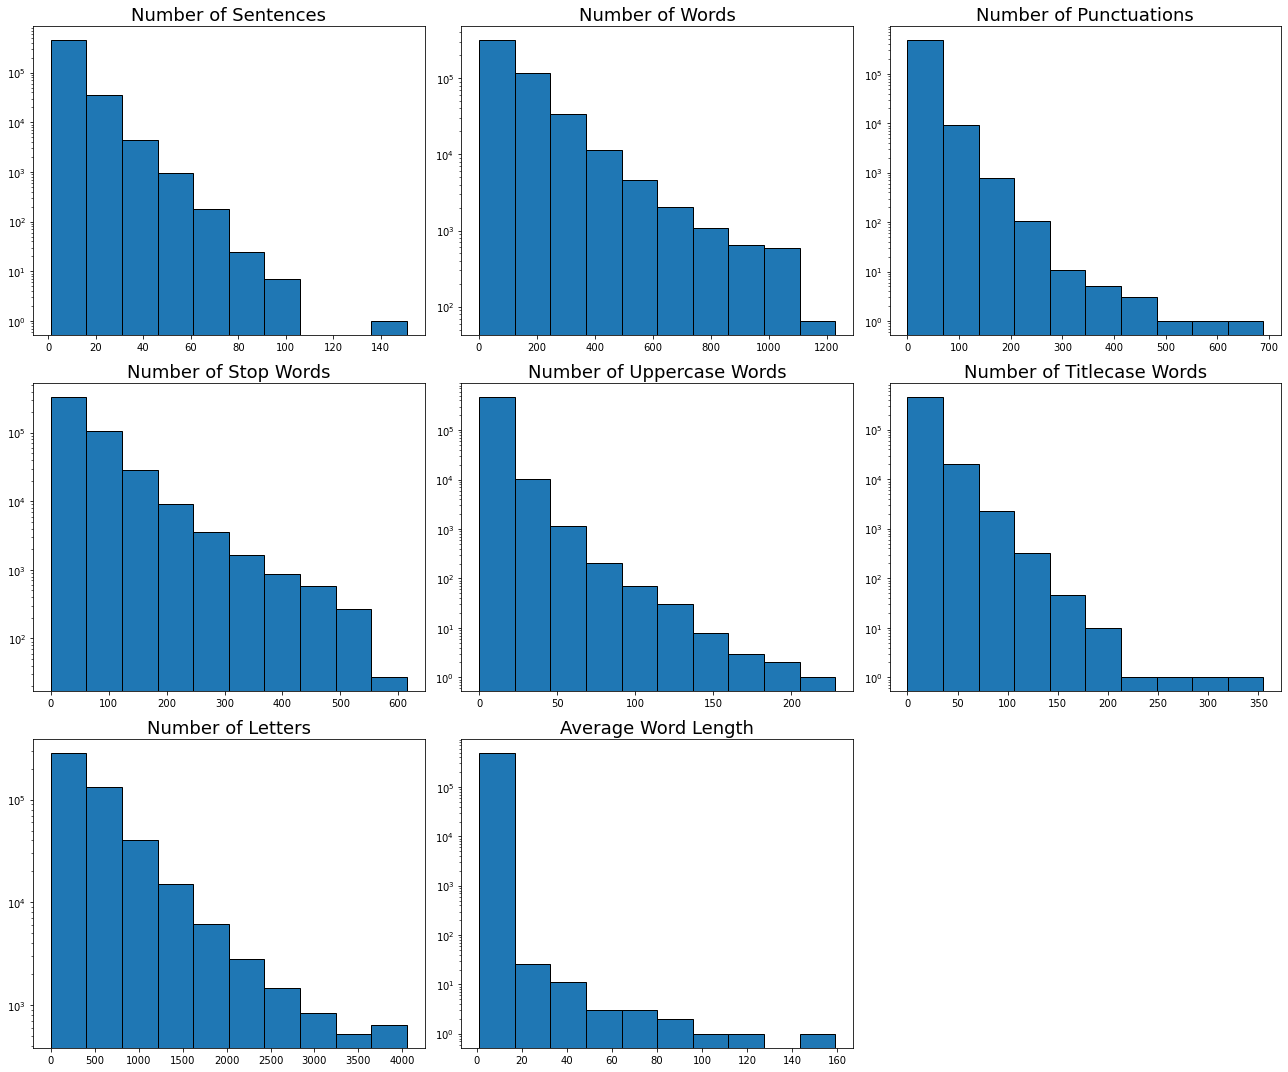

In [9]:
features = ['length_sent', 'length_word', 'length_punct', 'length_stopwords',
            'length_upper', 'length_title', 'length_char', 'average_length_words']
titles = ['Number of Sentences', 'Number of Words', 'Number of Punctuations',
          'Number of Stop Words', 'Number of Uppercase Words', 
          'Number of Titlecase Words', 'Number of Letters', 'Average Word Length']
d = dict(zip(features, titles))
# compare distributions of features by class in order to find the
# features that can identify fraudulent transactions
fig, axes = plt.subplots(3, 3) # generates figure and axis objects
fig.set_size_inches([18,15]) # adjust the figure size in inches
axes = axes.flatten()
for feature, ax in zip(d.keys(), axes):
    # plot the distribution of not helpful
    ax.hist(df[feature].values, edgecolor='k')
    ax.set_yscale('log')
    ax.set_title(d[feature], size=18)
plt.delaxes(axes[-1])
plt.tight_layout()
plt.show()

* The histograms are log-scaled in order to see extreme values.
* __Average Word Length__ and __Number of Punctuations__ have suspicious values.

In [10]:
df[df.average_length_words > 20].loc[:, ['review', 'average_length_words']].head()

,review,average_length_words
23351,今回はSamsung Gear S2 4G版をプリペイド契約で可能かを聞きに行ってきましたが...,30.25
25253,很棒的一家連鎖超市.商品的品質口味適合嗎？好壞？未開封都不知道.只要您有一點意願購買.他們立...,51.00
40372,20年程前にロサンゼルス在住の友達に教えてもらい、その後どの都市に行っても探して買い物に行っ...,41.25
51533,這是一家連鎖超市.商品很多.包括生鮮食品.蔬果.肉類.冷凍食品.冰品.雜糧.麵包.藥物.清潔...,26.00
60029,ここのGoodwillは他と比べると綺麗な感じがする。\n陳列棚も整理されてて見やすかったで...,20.25


* Reviews with higher average length word is tend to belong to another language
* Let's detect the language of each review and keep only English

In [11]:
def get_language(text):
    try:
        return detect(text)
    except:
        return 'error'

In [12]:
df['language'] = df.review.apply(get_language)

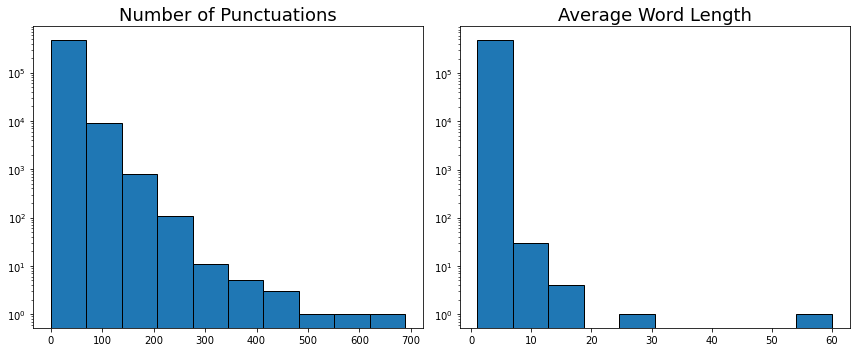

In [13]:
df = df[df.language == 'en']
features = ['length_punct', 'average_length_words']
titles = ['Number of Punctuations', 'Average Word Length']
d = dict(zip(features, titles))
# compare distributions of features by class in order to find the
# features that can identify fraudulent transactions
fig, axes = plt.subplots(1, 2) # generates figure and axis objects
fig.set_size_inches([12, 5]) # adjust the figure size in inches
axes = axes.flatten()
for feature, ax in zip(d.keys(), axes):
    # plot the distribution of not helpful
    ax.hist(df[feature].values, edgecolor='k')
    ax.set_yscale('log')
    ax.set_title(d[feature], size=18)
plt.tight_layout()
plt.show()

In [14]:
df.reset_index(drop=True, inplace=True)
temp = df[df.average_length_words > 6].loc[:, [
    'review_id', 'review', 'average_length_words', 'language', 'review_useful']]
display(temp.head())
for idx, review in zip(temp.index, temp.review.values):
    print(idx)
    print(review)
    print('-' * 80, end='\n\n')

,review_id,review,average_length_words,language,review_useful
15099,u6oRV98Oqhe2X7mR6KIeJQ,CCW course instructors are extremely professio...,6.303030,en,0
22612,cF1jYxvgHXoIN0AO5P78pQ,Warning avoid this location completely.... hor...,6.625000,en,8
28307,64KnvdzFZzSBGT0Hn9CvZw,Be very careful of this establishment. They j...,7.418605,en,1
37668,gWoNdTCX7jcN0wvMF9nvkA,Excellent lounge extremely friendly staff and ...,7.272727,en,2
38900,E8D14Bh0mw1j10O4xGp1yQ,https://patch.com/pennsylvania/pittsburgh/pitt...,14.625000,en,0


15099
CCW course instructors are extremely professional, knowledgable and friendly. Geza and Darius delivered an engaging and informative presentation of incredible value.
Their commitment is unparalleled and appreciated.Highly recommended!!
--------------------------------------------------------------------------------

22612
Warning avoid this location completely.... horrible service
--------------------------------------------------------------------------------

28307
Be very careful of this establishment.  They just received an 82 sanitary rating.  Beware!
Here is their rating on their latest inspecition:

https://www.bizjournals.com/charlotte/news/2017/09/08/which-mecklenburg-county-restaurants-didnt-make.html?ana=e_me_set1&s=scroll&ed=2017-09-08&u=bB8v3OOWQQrLT0a13p%2FK2w06587473&t=1504876484&j=78797771
--------------------------------------------------------------------------------

37668
Excellent lounge extremely friendly staff and owners friendly customers
Highly recommende

* As seen above, `http` and `https` links change the average length of word feature, dramatically.
* It is required to discard all links during text normalization.
* Manual check after language detection may be required.
* URLs and consecutive punctuations inflated __Average Length of Words__ and __Number of Punctuation__

In [15]:
# manually correction of reviews
missing_text = 'Great place to handle all your families eye care needs. Staff is friendly and knowledgeable. They have always done a great job with my daughter.'
df.loc[df.review.apply(lambda x: x.startswith('Greatplacetohandleallyourfa')), 'review'] = missing_text
# drop non-english review
df.drop(135564, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
# save to a csv file
df.to_csv('text_basic_features.csv', index=False)

# Data Cleaning

In [16]:
# remove urls from reviews
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [17]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [18]:
# remove urls
data = df.loc[:, ['review_id', 'review', 'review_stars', 'review_useful']]
data['review_clean'] = data.review.apply(remove_url)
# remove emoji
data.review_clean = data.review_clean.apply(remove_emoji)
# separate hyphen words
data.review_clean = data.review_clean.apply(lambda x: x.replace('-', ' '))
# replace $ as a text
data.review_clean = data.review_clean.apply(
    lambda x: x.replace('$ ', 'dollar').replace('$', 'dollar '))
# fix contractions such as I'm -> I am
data.review_clean = data.review_clean.apply(contractions.fix)
# remove hashtags and mentions
data.review_clean = data.review_clean.apply(lambda x: re.sub(r"(?:\@|#)\S+", "", x))
# replace punctuations with whitespace
data.review_clean = data.review_clean.apply(
    lambda x: re.sub(r"""[!"#$%&\'()*+,-./:;<=>?@\[\]^_`{|}~€£¥]""", " ", x))
# remove digits
data.review_clean = data.review_clean.apply(
    lambda x: ''.join([char for char in x if char not in digits]))
# remove stopwords
data.review_clean = data.review_clean.apply(
    lambda x: ' '.join([w.lower() for w in nltk.word_tokenize(x)
                        if w.lower() not in stop_words]))
# lemmatizer
data.review_clean = data.review_clean.apply(lambda x: nlp(x))
# stemmer
data.review_clean = data.review_clean.apply(
    lambda x: ' '.join([snowball_stemmer.stem(w) for w in [token.orth_ for token in x]]))
# drop if review is empty string
data = data.loc[data.review_clean != '']

In [19]:
# Feature engineering
data['length_word'] = data.review_clean.apply(lambda x: len(x.split()))
data['set_word'] = data.review_clean.apply(lambda x: len(set(x.split())))
data['length_char'] = data.review_clean.apply(lambda x: len([char for char in x if char not in whitespace]))
data['average_length_words'] = data.review_clean.apply(lambda x: np.mean([len(w) for w in x.split()]))

In [30]:
temp = df.loc[:, ['review_id', 'length_sent', 'length_punct', 'length_stopwords', 'length_upper', 'length_title']]
data = data.merge(temp, on='review_id', validate='one_to_one')

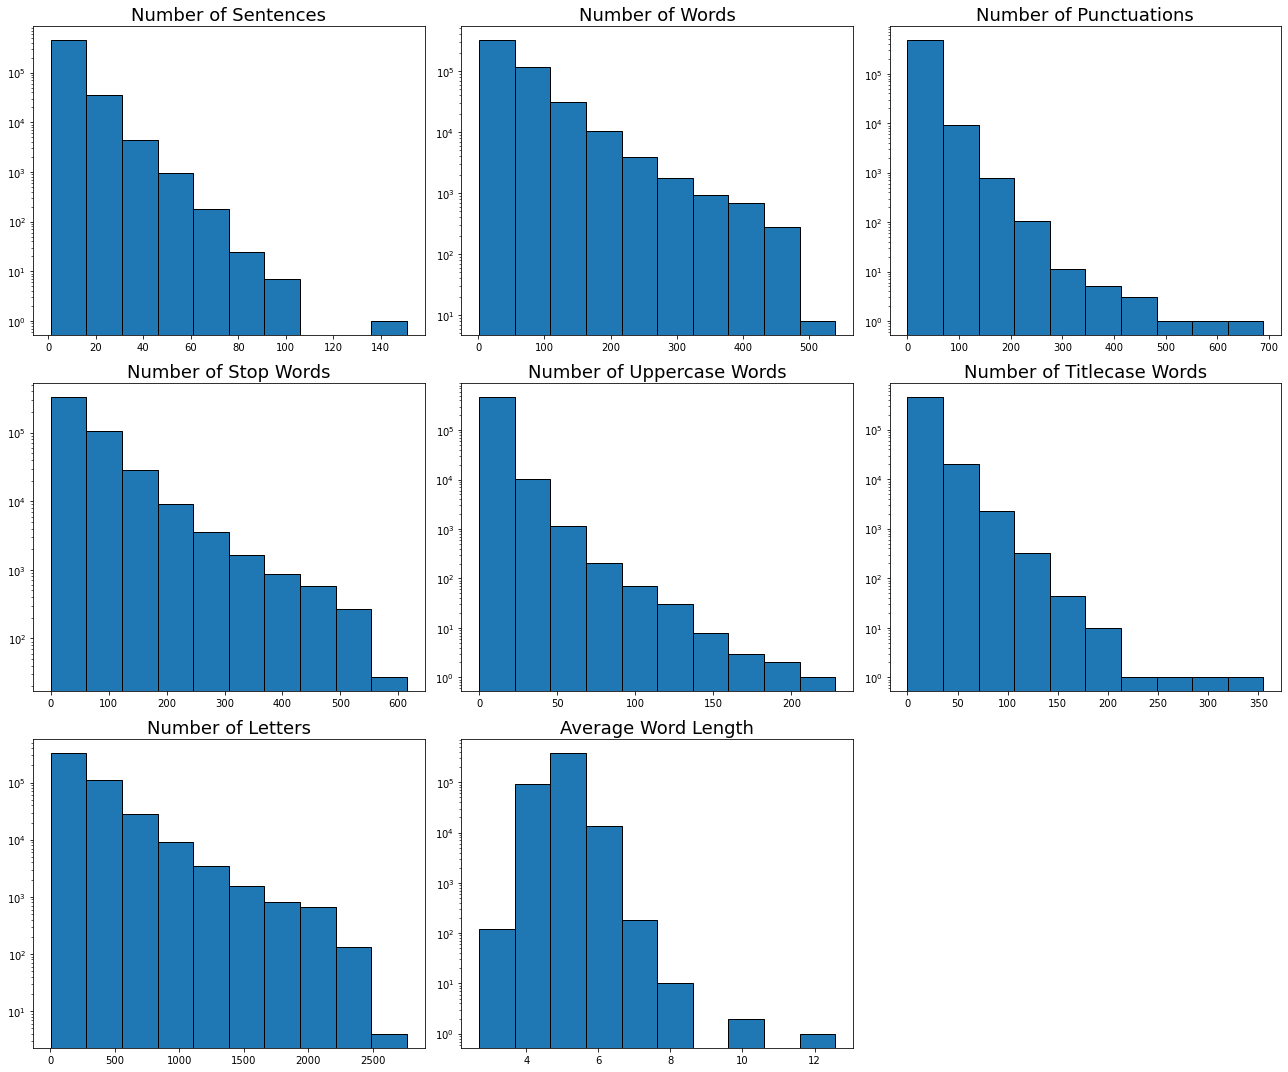

In [31]:
features = ['length_sent', 'length_word', 'length_punct', 'length_stopwords',
            'length_upper', 'length_title', 'length_char', 'average_length_words']
titles = ['Number of Sentences', 'Number of Words', 'Number of Punctuations',
          'Number of Stop Words', 'Number of Uppercase Words', 
          'Number of Titlecase Words', 'Number of Letters', 'Average Word Length']
d = dict(zip(features, titles))
# compare distributions of features by class in order to find the
# features that can identify fraudulent transactions
fig, axes = plt.subplots(3, 3) # generates figure and axis objects
fig.set_size_inches([18,15]) # adjust the figure size in inches
axes = axes.flatten()
for feature, ax in zip(d.keys(), axes):
    # plot the distribution of not helpful
    ax.hist(data[feature].values, edgecolor='k')
    ax.set_yscale('log')
    ax.set_title(d[feature], size=18)
plt.delaxes(axes[-1])
plt.tight_layout()
plt.show()

In [32]:
for review in data[data.average_length_words > 7].review_clean.values:
    print(review)
    print()

salesperson cameron stansberri great total profession

nicol phenomen esthetician

great job profession punctual recommend servic technician respons friend

absolut recommend pharmaci pharmacist knowledg friend

probabl unprofession photograph town patienc studio filthi

courteous friend profession step compar competitor street

optometrist necessarili thorough shop staff friend small inventori

blackhawk hardwar garden fantast

main respons balloon helium extrem unaccept unprofession

darryl great met profession high recommend xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

serv purpos brilliant architectur

cooooooollllllll personnel friend line long

unprofession servic would recommend

faaaaaaaaaaaaaaaaaaaaaanci fanci fanci fancyp

zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz averag american make somewher dollar k k year like place window shop mani store cater top popul trust fund babi shallow credit card whore zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz uniqu artist touch 

* The reviews are pretty clean
* There are some problematic reviews; however they will not be counted into the text vector since we will apply threshold or cut-off

In [33]:
data[data.length_word < 3]

,review_id,review,review_stars,review_useful,review_clean,length_word,set_word,length_char,average_length_words,length_sent,length_punct,length_stopwords,length_upper,length_title
35464,qZd55U0mTOMOwvc5RCmlZg,Wow what a selection!,5.0,1,wow select,2,2,9,4.5,1,1,2,0,1
40230,27a46ILlo450hjNC-irvvw,Great place,5.0,0,great place,2,2,10,5.0,1,0,0,0,1
88212,QNqJgxhnTN6GD5iroyeTFg,Very helpful staff.,5.0,2,help staff,2,2,9,4.5,1,1,1,0,1
91094,xNDFBCUBp_x3k728Da3zeg,of course!,5.0,0,cours,1,1,5,5.0,1,1,1,0,0
91727,698Ip0pfefvvUEgcwvKUSA,did not have the best experience.,1.0,0,best experi,2,2,10,5.0,1,1,4,0,0
169108,DgmlfZym6x8FYT6Arv7pBw,Not a good place,1.0,2,good place,2,2,9,4.5,1,0,2,0,1
174245,PUiiNwDPV3YAEzMYYrUvwA,Big selection!,3.0,0,big select,2,2,9,4.5,1,1,0,0,1
185409,Kpj4x0-m3von9EHtLgcBKw,Cool,5.0,0,cool,1,1,4,4.0,1,0,0,0,1
223726,11uid_sgVDCmRB78BCNzrw,just another outlet,3.0,0,anoth outlet,2,2,11,5.5,1,0,1,0,0
224011,wxN3kHb4YV7sZQ1Suq9TbA,love the eagle!,4.0,0,love eagl,2,2,8,4.0,1,1,1,0,0


In [34]:
data.to_csv('yelp_review_processed.csv', index=False)

# Cumulative Distribution of Words

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
vectorized = cv.fit_transform(data.review_clean)

In [38]:
from collections import Counter
# generates a matrix of frequency for each word
# frequencies.size equals to number of unique words in the whole text
frequencies = np.sum(vectorized, axis=0)
# how many times each frequency occurs in the frequency array
# e.g. how many words appeared in the text exactly 1 time
# `[0]` selects the inside matrix where the frequencies are
# sum of the values of `counts_of_frequency` gives the number of unique words
counts_of_frequency = Counter(np.asarray(frequencies)[0])
# calculates percent for each frequency i.e.
# how many percent of data is belong to a frequency
# for example 1 frequency is 40% means that all words that appear
# in the text one time accounts for 40% of all words
percents = [counts_of_frequency[i] / frequencies.size for i in range(frequencies.size)]
# calculates the cummulative frequency
cumulative_frequency = np.cumsum(percents)

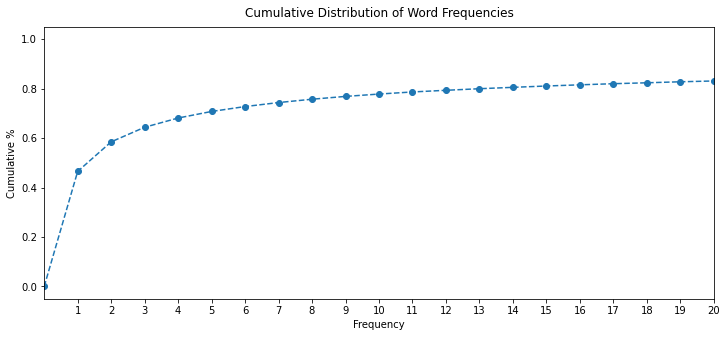

In [72]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(frequencies.size), cumulative_frequency, marker='o', linestyle='--')
ax.set_xlim(0, 20)
ax.set_xticks(range(1, 21))
ax.set_xticklabels(range(1, 21))
ax.set_xlabel('Frequency')
ax.set_ylabel('Cumulative %')
ax.set_title('Cumulative Distribution of Word Frequencies', pad=10)
plt.show()

In [73]:
words_freq = [(word, frequencies[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [74]:
# top 20 most frequent words
pd.DataFrame({'Word Top 20': [word for word, _ in words_freq[:20]],
              'Frequency Top 20' : ['{:,}'.format(freq) for _, freq in words_freq[:20]],
              'Word Bottom 20': [word for word, _ in words_freq[-20:]],
              'Frequency Bottom 20' : ['{:,}'.format(freq) for _, freq in words_freq[-20:]]},
              index=range(20))

,Word Top 20,Frequency Top 20,Word Bottom 20,Frequency Bottom 20
0,store,"255,566",arrivedtheir,1
1,get,"216,311",margold,1
2,time,"216,213",oversatisfi,1
3,would,"210,095",diphtheria,1
4,go,"199,731",flashdanc,1
5,great,"184,794",rhinopharyng,1
6,one,"182,033",nailgun,1
7,place,"173,700",fortess,1
8,servic,"172,581",refillb,1
9,like,"169,954",ferro,1


* In the above figure and table, we see that words that occur only one time in the corpus accounts for ~45% of the vocabulary.
* Moreover, the number of occurrence has a marginal effect of the cumulative distribution. In other words, the curve gets flatter as we move to the right of the graph.